# Motivation

The notebook studies the volatility and returns of the S&P 500 index

Assumptions:
- Using historical market cap data from macrotrends
- Calculate returns based on historical close prices

| Use Case                           | Use Log Return Volatility    | Use Arithmetic Volatility |
| ---------------------------------- | ---------------------------- | ------------------------- |
| Theoretical models (e.g., GBM)     | ✅                            | ❌                         |
| Sharpe ratio, risk-adjusted return | ❌                            | ✅                         |
| Empirical finance, EDA             | ✅                            | ✅                         |
| Long horizon compounding           | ✅                            | ❌                         |
| Portfolio optimization             | Mixed (depends on framework) | ✅                         |

- Arithmetic returns is more intuitive and is used in Sharpe ratio calculations
- Log-returns are more convenient for theoretical models (e.g., Geometric Brownian Motion for compounding drift)

## Equations:
- Arithmetic Return (Simple or Percentage Return)
   - $r_t^{\text{arith}} = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1$

- Log Return (Continuously Compounded Return)
   - $r_t^{\text{log}} = \ln\left( \frac{P_t}{P_{t-1}} \right)$

- Relationship Between Log and Arithmetic Returns
  - $r_t^{\text{arith}} = e^{r_t^{\text{log}}} - 1$
  - $r_t^{\text{log}} = \ln(1 + r_t^{\text{arith}})$

- Taylor Expansion of Log Return (Around 0)
  - $ \ln(1 + r) = r - \frac{r^2}{2} + \frac{r^3}{3} - \frac{r^4}{4} + \cdots $
  - $\Rightarrow r_t^{\text{log}} \approx r_t^{\text{arith}} - \frac{1}{2} \left( r_t^{\text{arith}} \right)^2$
  - Note: if small changes then log return is close to arithmetic return

- Cumulative Return (Arithmetic)
  - $R_{0 \to T}^{\text{arith}} = \prod_{t=1}^T (1 + r_t^{\text{arith}}) - 1$

- Cumulative Return (Log)
  - $R_{0 \to T}^{\text{log}} = \sum_{t=1}^T r_t^{\text{log}} = \ln\left( \frac{P_T}{P_0} \right)$

- Annualization of Mean and Volatility
  - Multiplying mean by $N$ and volatility by $\sqrt{N}$ is **exact property of expectations under iid constant mean processes**
  - Assuming $N$ trading periods per year (e.g., 252 for daily returns):
  - Annualized Mean Return (Log):
    - $\mu_{\text{annual}}^{\text{log}} = N \cdot \bar{r}_{\text{log}}$
  - Annualized Mean Return (Arithmetic):
    - $\mu_{\text{annual}}^{\text{arith}} = N \cdot \bar{r}_{\text{arith}}$
  - Annualized Volatility (Both Types):
    - $\sigma_{\text{annual}} = \sqrt{N} \cdot \sigma_{\text{daily}}$

| Model                              | Purpose / Description                                                                                                                                                                                                                   | When to Use                                                                                                                                                                                    | Pros                                                                                                                                                                                  | Cons                                                                                                                                                                                     |
|------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Discounted Cash Flow (DCF)**     | Projects a company’s future free cash flows (FCF) to equity or to the firm and discounts them to present value using a chosen discount rate (typically WACC or cost of equity).                                                          | When you have reliable forecasts for revenue growth, margins, capex, and working capital; especially for established companies with reasonably predictable cash flows.                         | • Directly ties valuation to underlying cash-flow drivers<br>• Flexible: can model changing revenue, margins, capex, working capital, etc.<br>• Widely accepted as an “intrinsic” approach | • Highly sensitive to assumptions (growth rates, margins, discount rate)<br>• Terminal value often dominates—small tweaks in terminal inputs swing valuation<br>• Data-intensive        |
| **Dividend Discount Model (DDM)** / **Gordon Growth** | Values a stock as the present value of expected future dividends. <br>• Constant-growth form: $P_0 = \dfrac{D_1}{r - g}$ assumes dividends grow at a fixed rate $g$ forever.                                                                      | When the firm has a stable dividend policy and predictable payout ratio (e.g., utility companies, large blue-chips).                                                                            | • Very simple in constant-growth case (single formula)<br>• Directly captures yield + growth trade-off<br>• Ideal for mature, stable dividend payers                                   | • Only works for firms with predictable dividends (not for non-dividend payers)<br>• Assumes perpetual, constant growth ($g < r$)—hard to justify for high-growth or cyclical stocks |
| **Relative Valuation (Multiples)** | Values a stock by comparing its valuation multiples (P/E, EV/EBITDA, P/B, etc.) to a set of comparable peers. <br>Example: If Company A trades at 15× EV/EBITDA and Company B (similar profile) trades at 10×, B may be “cheap.”         | When you need a quick “sanity check” or peer comparison; suitable for sectors with homogeneous business models (e.g., retail, manufacturing) and readily available multiples.                | • Quick to implement—only needs market prices and basic financial metrics<br>• Reflects current market sentiment (peer pricing)<br>• Common sanity check alongside DCF/DDM               | • Requires a truly comparable peer group—difficult if no close peers exist<br>• Ignores company-specific fundamentals unless adjusted<br>• Market multiples can be temporarily distorted   |
| **Residual Income (RI) / EVA**     | Values equity as $P_0 = B_0 + \sum_{t=1}^{\infty} \dfrac{(ROE_t - r_e)\,B_{t-1}}{(1 + r_e)^t}$, where $B_t$ is book value at time $t$ and $r_e$ is cost of equity. Focuses on “excess” accounting profits above required return. | When dividends or FCF are erratic but accounting profits (ROE) are steady; useful for banks or insurance companies where book value and ROE are more stable metrics than cash flows.         | • Captures value created above cost of equity—suitable when FCF or dividends are erratic<br>• Connects accounting (book) to market value                                                 | • Requires reliable forecasts of future ROE and book value—often uncertain<br>• Sensitive to the choice of cost of equity $r_e$<br>• Less intuitive if reinvestment returns vary         |


In [287]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import pandas as pd
import yfinance as yf
from rich import box
from rich.console import Console
from rich.markdown import Markdown
from rich.panel import Panel
from rich.table import Table
from scipy import stats
from scipy.stats import norm, truncnorm, uniform

from fundamentals.utility.dcf import StandardDCFModel
from fundamentals.utility.general import update_plot_style

console = Console()

update_plot_style()

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.3f}'.format)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [215]:
sp500 = pd.read_parquet("../../macro_data/SP500_2025-03-31.parquet")

In [288]:
macrotrends = {}
# for ticker in ["AAPL"]:
for ticker in sp500.ticker.values:
    macrotrends[ticker] = pd.read_parquet(f"../../macro_data/parquet/{ticker}_2025-03-31.parquet")
    if len(macrotrends[ticker]) == 0:
        print(f"Warning: {ticker} has no macrotrends data")

In [217]:
start_date = next(iter(macrotrends.values())).index[-5]
end_date   = next(iter(macrotrends.values())).index[-1]

In [218]:
assert (end_date - start_date).days == 365 # ensure 1 year

In [219]:
tickers = " ".join(sp500.ticker.values)

# Use open price for the price
data = yf.download(tickers, start=start_date, end=end_date, interval='1d', group_by='ticker', auto_adjust=True)
open_data = data.xs('Open', axis=1, level='Price')

[*********************100%***********************]  503 of 503 completed


In [220]:
market_caps = {'ticker': [], 'marketCap': []}
for ticker, df in macrotrends.items():
    market_caps['ticker'].append(ticker)
    length_df = len(df['Market-Cap'])
    market_cap = df['Market-Cap'].iloc[max(-1, length_df-5)]
    market_caps['marketCap'].append(market_cap)
market_caps = pd.DataFrame(market_caps)

market_caps.index = market_caps.ticker
market_caps.drop(columns=['ticker'], inplace=True)
market_caps = market_caps.reindex(open_data.columns)

In [221]:
# 1. Compute daily log and arithmetic returns
logret = np.log(open_data / open_data.shift(1)).dropna()
arithret = open_data.pct_change().dropna()
trading_days = 252

# 2. Annualized volatility and mean
ann_vol_log = logret.std(axis=0) * np.sqrt(trading_days)
ann_vol_arith = arithret.std(axis=0) * np.sqrt(trading_days)
ann_mean_log = logret.mean(axis=0) * trading_days
ann_mean_arith = arithret.mean(axis=0) * trading_days
ann_ret_from_log = np.exp(ann_mean_log) - 1

# 3. Annualized volatility (cross-section)
#    vol_i = std(logret_i) * sqrt(trading_days)
ann_vol = logret.std(axis=0) * np.sqrt(trading_days)

# 4. Index weights (as of start date)
weights = market_caps['marketCap'].values / market_caps['marketCap'].sum()

# 5. Total returns over the year per ticker
tot_ret = (open_data.iloc[-1] / open_data.iloc[0] - 1)

assert np.isclose(sum(weights), 1)
assert sum(market_caps.index == tot_ret.index) == len(market_caps), f"market_caps.index: {market_caps.index} != tot_ret.index: {tot_ret.index}"

# 6. Contribution to index return
contrib = weights * tot_ret
contrib_sorted = contrib.sort_values(ascending=False)
contrib_sorted = contrib_sorted.reset_index()
contrib_sorted.columns = ['ticker', 'contribution']

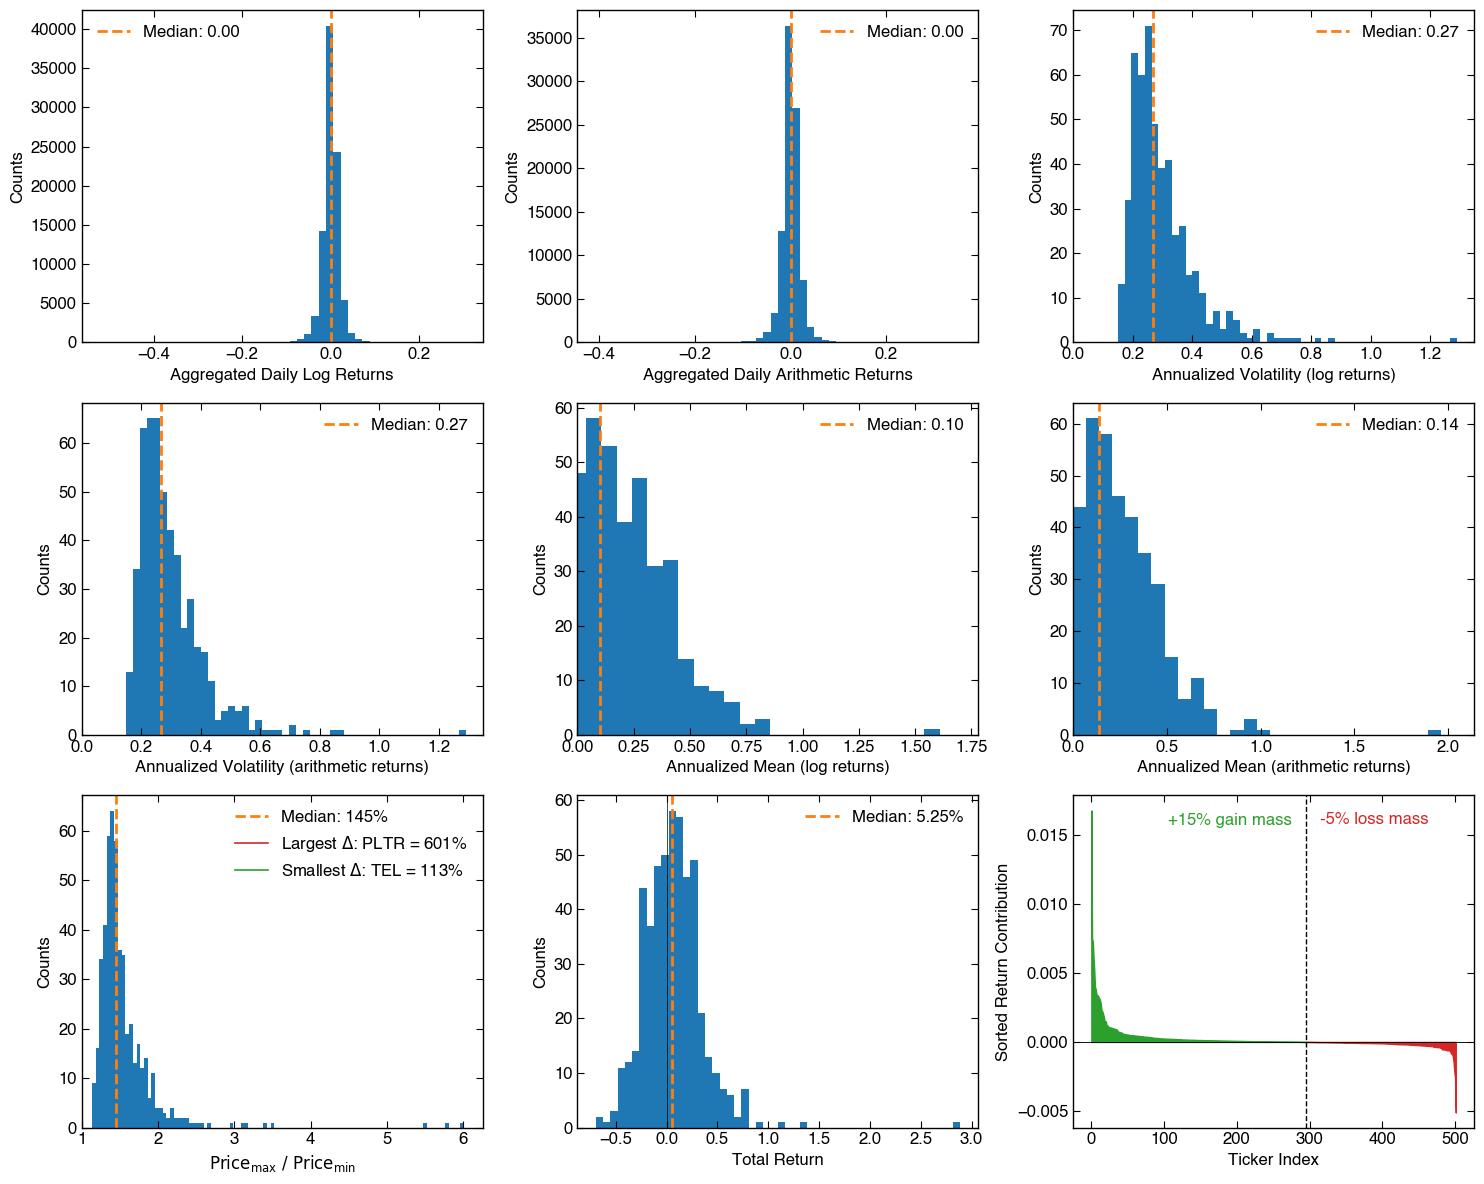

In [222]:
fig, axes = plt.subplots(3, 3, figsize=(15,12))
axes = axes.flatten()

iax = 0
all_logret = logret.values.flatten()
axes[iax].hist(all_logret, bins=50)
axes[iax].axvline(np.median(all_logret), color='tab:orange', linewidth=2, linestyle='--', label=f'Median: {np.median(all_logret):.2f}')
axes[iax].set_xlabel("Aggregated Daily Log Returns")
axes[iax].set_ylabel("Counts")
axes[iax].legend()

iax = 1
all_arithret = arithret.values.flatten()
axes[iax].hist(all_arithret, bins=50)
axes[iax].axvline(np.median(all_arithret), color='tab:orange', linewidth=2, linestyle='--', label=f'Median: {np.median(all_arithret):.2f}')
axes[iax].set_xlabel("Aggregated Daily Arithmetic Returns")
axes[iax].set_ylabel("Counts")
axes[iax].legend()

iax = 2
axes[iax].hist(ann_vol_log, bins=50)
axes[iax].axvline(np.median(ann_vol_log), color='tab:orange', linewidth=2, linestyle='--', label=f'Median: {np.median(ann_vol_log):.2f}')
axes[iax].set_xlabel("Annualized Volatility (log returns)")
axes[iax].set_ylabel("Counts")
axes[iax].set_xlim(0)
axes[iax].legend()

iax = 3
axes[iax].hist(ann_vol_arith, bins=50)
axes[iax].axvline(np.median(ann_vol_arith), color='tab:orange', linewidth=2, linestyle='--', label=f'Median: {np.median(ann_vol_arith):.2f}')
axes[iax].set_xlabel("Annualized Volatility (arithmetic returns)")
axes[iax].set_ylabel("Counts")
axes[iax].set_xlim(0)
axes[iax].legend()

idx = 4
axes[idx].hist(ann_mean_log, bins=50)
axes[idx].axvline(np.median(ann_mean_log), color='tab:orange', linewidth=2, linestyle='--', label=f'Median: {np.median(ann_mean_log):.2f}')
axes[idx].set_xlabel("Annualized Mean (log returns)")
axes[idx].set_ylabel("Counts")
axes[idx].set_xlim(0)
axes[idx].legend()

iax = 5
axes[iax].hist(ann_mean_arith, bins=50)
axes[iax].axvline(np.median(ann_mean_arith), color='tab:orange', linewidth=2, linestyle='--', label=f'Median: {np.median(ann_mean_arith):.2f}')
axes[iax].set_xlabel("Annualized Mean (arithmetic returns)")
axes[iax].set_ylabel("Counts")
axes[iax].set_xlim(0)
axes[iax].legend()

# Maximum price range distribution
iax = 6
max_delta_pct = open_data.max(axis=0) / open_data.min(axis=0)
median_delta = max_delta_pct.median()
highest_delta = max_delta_pct.idxmax()
smallest_delta = max_delta_pct.idxmin()
axes[iax].hist(max_delta_pct, bins=100)
axes[iax].axvline(median_delta, color='tab:orange', linewidth=2, linestyle='--', label=f'Median: {median_delta:.0%}')
axes[iax].plot([], [], label=f"Largest $\\Delta$: {highest_delta} = {max_delta_pct[highest_delta]:.0%}", color='tab:red')
axes[iax].plot([], [], label=f"Smallest $\\Delta$: {smallest_delta} = {max_delta_pct[smallest_delta]:.0%}", color='tab:green')
axes[iax].legend()
axes[iax].set_xlim(1)
axes[iax].set_ylabel("Counts")
axes[iax].set_xlabel(r"$\text{Price}_{\text{max}}~/~\text{Price}_{\text{min}}$")

# Total Return Distribution
iax = 7
median_ret = tot_ret.median()
axes[iax].hist(tot_ret, bins=50)
axes[iax].set_xlabel('Total Return')
axes[iax].set_ylabel('Counts')
axes[iax].axvline(0, color='black', linewidth=0.5)
axes[iax].axvline(median_ret, color='tab:orange', linewidth=2, linestyle='--', label=f'Median: {median_ret:.2%}')
axes[iax].legend()

# Sorted return contribution
iax = 8
gain_to_loss_index = contrib_sorted[contrib_sorted['contribution'] > 0].index[-1]
gain_mass = contrib_sorted.loc[:gain_to_loss_index, 'contribution'].sum()
loss_mass = contrib_sorted.loc[gain_to_loss_index:, 'contribution'].sum()
axes[iax].fill_between(range(0, gain_to_loss_index+1), contrib_sorted.loc[:gain_to_loss_index, 'contribution'].values, color='tab:green')
axes[iax].fill_between(range(gain_to_loss_index, len(contrib_sorted)), contrib_sorted.loc[gain_to_loss_index:, 'contribution'].values, color='tab:red')
axes[iax].axvline(gain_to_loss_index, color='black', linewidth=1, linestyle='--')
axes[iax].axhline(0, color='black', linewidth=0.5)
axes[iax].text(gain_to_loss_index-20, axes[iax].get_ylim()[1]*0.9, f'+{gain_mass:.0%} gain mass', color='tab:green', ha='right', va='center')
axes[iax].text(gain_to_loss_index+20, axes[iax].get_ylim()[1]*0.9, f'{loss_mass:.0%} loss mass', color='tab:red', ha='left', va='center')
axes[iax].axhline(0, color='black', linewidth=0.5)
axes[iax].set_xlabel('Ticker Index')
axes[iax].set_ylabel('Sorted Return Contribution')

plt.tight_layout()

In [223]:
# Print paragraph of summary
md = Markdown(f"""
The S&P 500 index has a median annualized volatility of {np.median(ann_vol_arith):.2%} and a median price range (Price_max / Price_min) of {median_delta:.0%}. The S&P 500 index has a median total return of {median_ret:.2%}. An attempt to compute the contribution of each ticker to the index return is currently misleading since the latest market cap data is used (baking in past returns again). With the current procedure, the gain mass is {gain_mass:.0%} and the loss mass is {loss_mass:.0%}.""")
console.print(md)

The S&P 500 index has a median annualized volatility of 26.72% and a median price range (Price_max / Price_min) of 
145%. The S&P 500 index has a median total return of 5.25%. An attempt to compute the contribution of each ticker  
to the index return is currently misleading since the latest market cap data is used (baking in past returns       
again). With the current procedure, the gain mass is 15% and the loss mass is -5%.